In [1]:
# @title Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from collections import defaultdict
from pprint import pprint

from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

import matplotlib.dates as mdates
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [2]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# drive_data_path = "/content/drive/Shareddrives/Ishango/Programs/AIMS_MSc_Theses_Supervision/AIWP/Project26_MLStacking/data/oliver/"
# df = pd.read_pickle(drive_data_path + "era5_ml_setup_500geopotential_32x64_2020.pkl")
# data_path = "/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/"

# data_path = "/content/drive/MyDrive/_shared/MastersProject/Data/"
# data_plot_path = "/content/drive/MyDrive/_shared/MastersProject/Plots/"

data_path="/content/drive/MyDrive/MastersProject/Data/"
data_plot_path="/content/drive/MyDrive/MastersProject/Plots/"


In [4]:
# @title Load forecasts & ERA5 truth

df =pd.read_pickle(data_path+"era5_ml_setup_500geopotential_32x64_2020.pkl")

lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]
# lead_times=[48]

for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    if lead_time == 48:
      df_aiwp_full = df_aiwp
    else:
      df_aiwp_full = df_aiwp_full.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

print(f"Shape of df :{df.shape}")
print(f"Shape of df_aiwp_full :{df_aiwp_full.shape}")



48
72
96
120
144
168
192
216
240
Shape of df :(1556480, 5)
Shape of df_aiwp_full :(1531904, 48)


In [5]:
# @title Merge ERA5 and Forecasts Across all lead times
full_df = df.merge(df_aiwp_full, on=["time", "longitude", "latitude"], how="outer")
print(full_df.shape)
full_df.head()


(1556480, 50)


,time,longitude,latitude,era5,area_weight,graphcast_lt48,pangu_lt48,neuralgcm_lt48,keisler_lt48,ifshres_lt48,...,graphcast_lt216,pangu_lt216,neuralgcm_lt216,keisler_lt216,ifshres_lt216,graphcast_lt240,pangu_lt240,neuralgcm_lt240,keisler_lt240,ifshres_lt240
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# @title Filter for subset of data for each lead time

def data_per_lead_time(df,lead_time):
  valid_time_lower = df['time'][0]+timedelta(days=int(lead_time/24))
  valid_time_upper = valid_time_lower + relativedelta(years=1)
  df_filtered = df[(df['time'] > valid_time_lower) & (df['time'] < valid_time_upper)]
  return df_filtered[['time','latitude','longitude',"era5","area_weight",
                      f'graphcast_lt{lead_time}',
                      f'pangu_lt{lead_time}',
                      f'neuralgcm_lt{lead_time}',
                      # f'keisler_lt{lead_time}'
                      f'ifshres_lt{lead_time}'
                      ]]


In [7]:
for lead_time in lead_times:
  print(f"========{lead_time}=======")
  df_filter=data_per_lead_time(full_df,lead_time)
  print(df_filter[df_filter.isna().any(axis=1)]["time"].value_counts())

========48=======
Series([], Name: count, dtype: int64)
========72=======
Series([], Name: count, dtype: int64)
========96=======
Series([], Name: count, dtype: int64)
========120=======
Series([], Name: count, dtype: int64)
========144=======
Series([], Name: count, dtype: int64)
========168=======
Series([], Name: count, dtype: int64)
========192=======
Series([], Name: count, dtype: int64)
========216=======
Series([], Name: count, dtype: int64)
========240=======
Series([], Name: count, dtype: int64)


In [8]:
# @title Plot the train-test splits for each Fold

def cross_validation_plot(df, cv, lead_time):
  # Extract datetime info using the filtered df
  time_index = df["time"].reset_index(drop=True)

  X = df[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
          f"neuralgcm_lt{lead_time}",
          # f"keisler_lt{lead_time}",
          f"ifshres_lt{lead_time}", "longitude", "latitude"]]

  # Store train/test index lists
  train_indices_list = []
  test_indices_list = []
  for train_index, test_index in cv.split(X):
      train_indices_list.append(train_index)
      test_indices_list.append(test_index)


  # Create the plot
  fig, ax = plt.subplots(figsize=(12, 6))

  # Plot each fold
  for i in range(10):
      # Convert indices to datetime for x-axis
      train_times = time_index.iloc[train_indices_list[i]]
      print(f"Train times Min Date: {train_times.min()} Train times Max Date:{train_times.max()}")
      test_times = time_index.iloc[test_indices_list[i]]
      print(f"Test times Min Date: {test_times.min()} Test times Max Date:{test_times.max()}")


      ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
      ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)
      ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

  # Format x-axis as months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

  # Labels and title
  ax.set_xlabel('Month')
  ax.set_ylabel('Fold')
  ax.set_yticks(range(1, 11))
  ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
  ax.set_title(f'Training, Gap and Testing Windows Across 10 Folds for {lead_time} hours lead time.')
  ax.legend(loc='upper right')

  # Improve layout and save
  plt.tight_layout()
  # plt.savefig(data_plot_path + f'Training_Testing_Folds_By_Month_{lead_time}.pdf',
  #             dpi=300, bbox_inches="tight")

  plt.show()


In [9]:
# @title RMSE Comparison for each model and fold

def train_and_evaluate(xgb, cv,X,y, area_weight,lead_time):
  # Create a dictionary to store the results for each fold
  results = {}

  for fold, (train_index, test_index) in enumerate(cv.split(X)):
      print(f"Fold {fold+1}:")
      fold_results = {}

      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      xgb.fit(X_train, y_train, sample_weight=area_weight.iloc[train_index])

      y_pred = xgb.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      print(f"  mse: {mse}")

      area_weighted_rmse = np.sqrt(((y_test-y_pred)**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
      print(f"  PiggyCast: area weighted rmse: {area_weighted_rmse}")
      fold_results["PiggyCast"] = area_weighted_rmse

      for model in [f"graphcast_lt{lead_time}",
                    f"pangu_lt{lead_time}",
                    f"neuralgcm_lt{lead_time}",
                    # f"keisler_lt{lead_time}",
                    f"ifshres_lt{lead_time}"]:
          area_weighted_rmse = np.sqrt(((y_test-X_test[model])**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
          print(f"  {model.split('_')[0]}: area weighted rmse: {area_weighted_rmse}")
          fold_results[model.split('_')[0]] = area_weighted_rmse

      results[fold+1] = fold_results
  return results



In [10]:
# @title Plot RMSE per fold and Model
def rmse_per_fold_plot(results, lead_time):
  fig, ax = plt.subplots(figsize=(8, 6))

  for model in results[1].keys():  # Iterate through all model names
      rmse_values = [results[fold][model] for fold in results]
      fold_numbers = list(results.keys())
      ax.plot(fold_numbers, rmse_values, label=model, marker='o')

  ax.set_xlabel('Fold')
  ax.set_ylabel('RMSE')
  ax.set_title(f'RMSE for Each Fold and Model at {lead_time} hours lead time.')
  ax.legend(loc="upper right")
  plt.grid(True)
  # plt.savefig(data_plot_path + f'RMSE_for_Each_Fold_and_Model_{lead_time}.pdf', dpi=300, bbox_inches="tight")

  plt.show()


In [11]:
# @title Calculate RMSE Mean of Model per Lead time

def rmse_mean_per_lead_time_and_model(rmse_results):
  # average scores per lead time and model
  average_scores = {}

  for lead_time, folds in rmse_results.items():
      model_scores = defaultdict(list)

      # collect values per model
      for fold_scores in folds.values():
          for model, value in fold_scores.items():
              model_scores[model].append(value)

      # average for each model
      average_scores[lead_time] = {model: float(np.mean(scores)) for model, scores in model_scores.items()}
  return average_scores



======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-03-03 12:00:00
Test times Min Date: 2020-03-09 00:00:00 Test times Max Date:2020-04-07 12:00:00
Train times Min Date: 2020-02-03 00:00:00 Train times Max Date:2020-04-02 12:00:00
Test times Min Date: 2020-04-08 00:00:00 Test times Max Date:2020-05-07 12:00:00
Train times Min Date: 2020-03-04 00:00:00 Train times Max Date:2020-05-02 12:00:00
Test times Min Date: 2020-05-08 00:00:00 Test times Max Date:2020-06-06 12:00:00
Train times Min Date: 2020-04-03 00:00:00 Train times Max Date:2020-06-01 12:00:00
Test times Min Date: 2020-06-07 00:00:00 Test times Max Date:2020-07-06 12:00:00
Train times Min Date: 2020-05-03 00:00:00 Train times Max Date:2020-07-01 12:00:00
Test times Min Date: 2020-07-07 00:00:00 Test times Max Date:2020-08-05 12:00:00
Train times Min Date: 2020-06-02 00:00:00 Train times Max Date:2020-07-31 12:00:00
Test times Min Date:

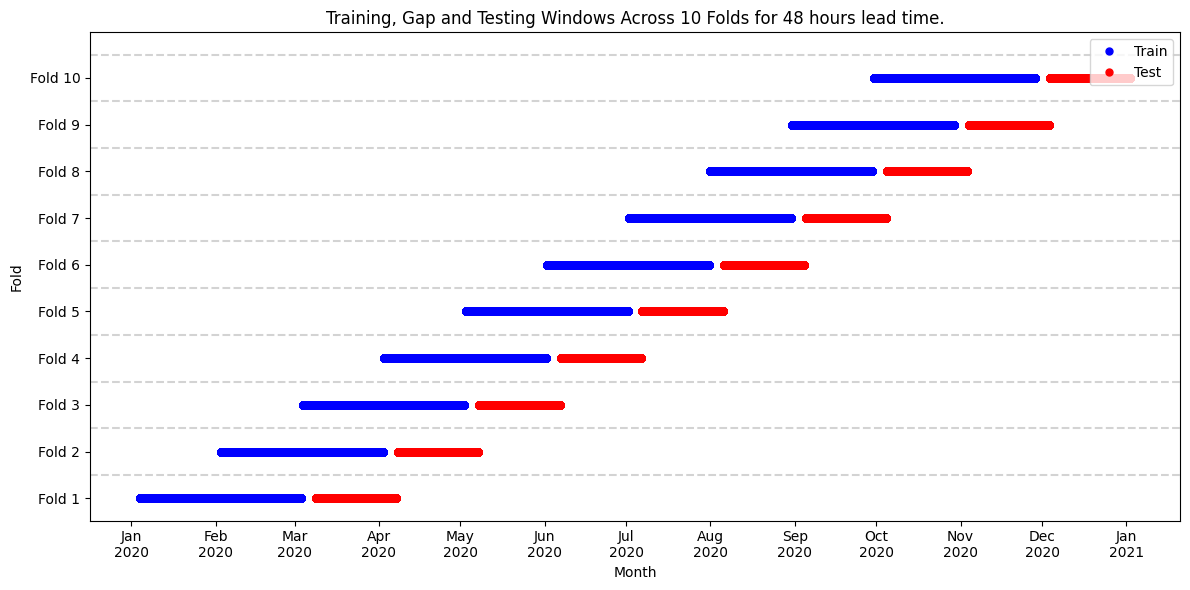

Fold 1:
  mse: 15209.0927734375
  PiggyCast: area weighted rmse: 76.76277746972184
  graphcast: area weighted rmse: 72.89521727913798
  pangu: area weighted rmse: 81.53557879205798
  neuralgcm: area weighted rmse: 61.32865112702906
  ifshres: area weighted rmse: 77.69317822238818
Fold 2:
  mse: 9210.8720703125
  PiggyCast: area weighted rmse: 66.86750469041097
  graphcast: area weighted rmse: 70.89595346008002
  pangu: area weighted rmse: 80.0969255422813
  neuralgcm: area weighted rmse: 62.04284877201307
  ifshres: area weighted rmse: 76.40121126092066
Fold 3:
  mse: 7203.16845703125
  PiggyCast: area weighted rmse: 64.48324208575639
  graphcast: area weighted rmse: 70.5749420055696
  pangu: area weighted rmse: 74.76480428843476
  neuralgcm: area weighted rmse: 61.50660557160111
  ifshres: area weighted rmse: 74.98039911101573
Fold 4:
  mse: 10929.08203125
  PiggyCast: area weighted rmse: 74.77433859172058
  graphcast: area weighted rmse: 67.91825353957019
  pangu: area weighted rmse:

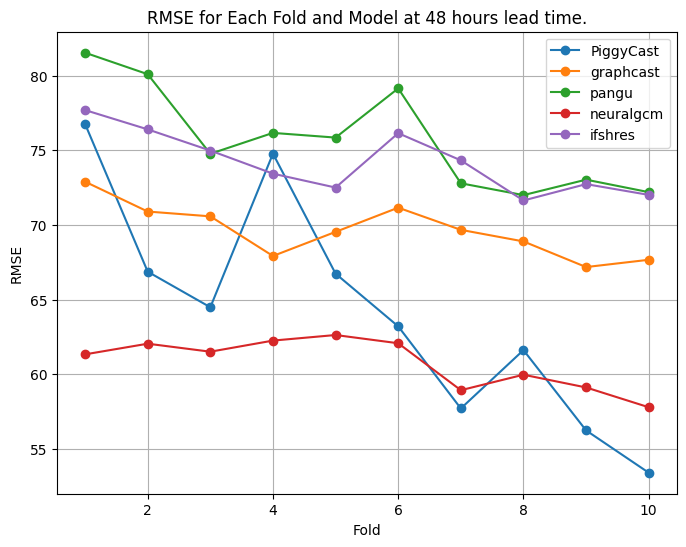

{48: {'PiggyCast': 64.1775584914425,
      'graphcast': 69.63800331707469,
      'ifshres': 74.18631782545808,
      'neuralgcm': 60.76147382469113,
      'pangu': 75.75723848328518}}
======Lead time: 72========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-05 00:00:00 Train times Max Date:2020-03-04 12:00:00
Test times Min Date: 2020-03-10 00:00:00 Test times Max Date:2020-04-08 12:00:00
Train times Min Date: 2020-02-04 00:00:00 Train times Max Date:2020-04-03 12:00:00
Test times Min Date: 2020-04-09 00:00:00 Test times Max Date:2020-05-08 12:00:00
Train times Min Date: 2020-03-05 00:00:00 Train times Max Date:2020-05-03 12:00:00
Test times Min Date: 2020-05-09 00:00:00 Test times Max Date:2020-06-07 12:00:00
Train times Min Date: 2020-04-04 00:00:00 Train times Max Date:2020-06-02 12:00:00
Test times Min Date: 2020-06-08 00:00:00 Test times Max Date:2020-07-07 12:00:00
Train times Min Date: 2020-05-04 00:00:00 Train times Max Date:2020-07-02 12:00:00


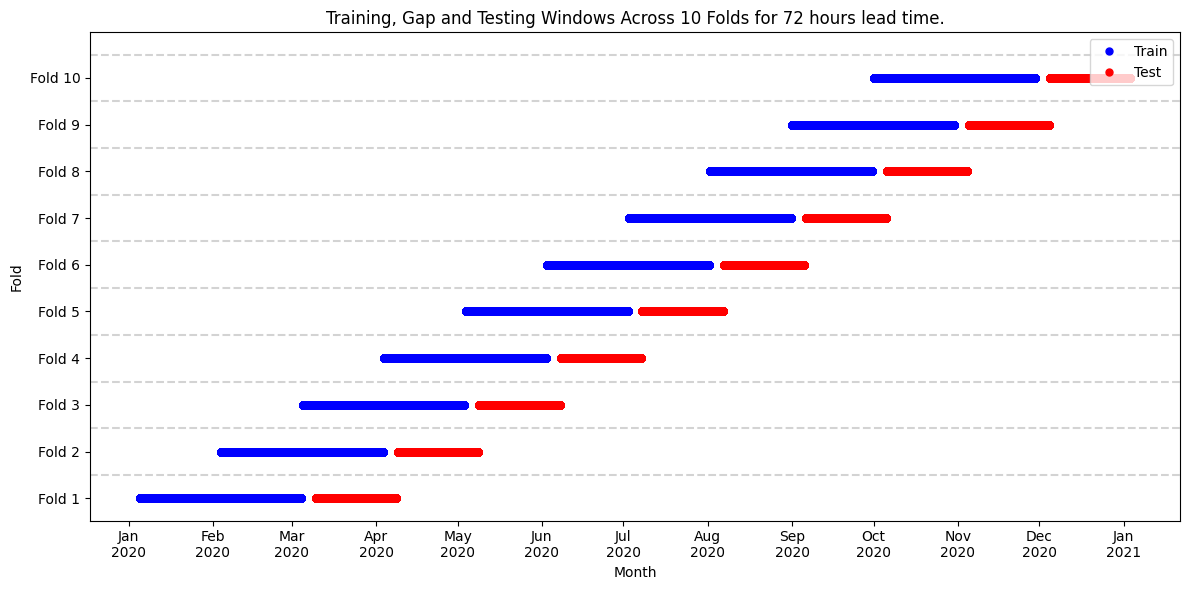

Fold 1:
  mse: 25877.22265625
  PiggyCast: area weighted rmse: 115.03192565675418
  graphcast: area weighted rmse: 122.85387708812033
  pangu: area weighted rmse: 135.08533958019098
  neuralgcm: area weighted rmse: 108.71967205337731
  ifshres: area weighted rmse: 131.52903243672063
Fold 2:
  mse: 20881.48046875
  PiggyCast: area weighted rmse: 107.9994745127202
  graphcast: area weighted rmse: 121.55502280923785
  pangu: area weighted rmse: 134.301915560045
  neuralgcm: area weighted rmse: 110.53258883735597
  ifshres: area weighted rmse: 130.6921929942073
Fold 3:
  mse: 16885.568359375
  PiggyCast: area weighted rmse: 102.35013330448703
  graphcast: area weighted rmse: 115.12777744553853
  pangu: area weighted rmse: 124.96075061143948
  neuralgcm: area weighted rmse: 106.80123183454789
  ifshres: area weighted rmse: 126.64768147865912
Fold 4:
  mse: 21867.5078125
  PiggyCast: area weighted rmse: 110.57140621198165
  graphcast: area weighted rmse: 113.60324813116003
  pangu: area weig

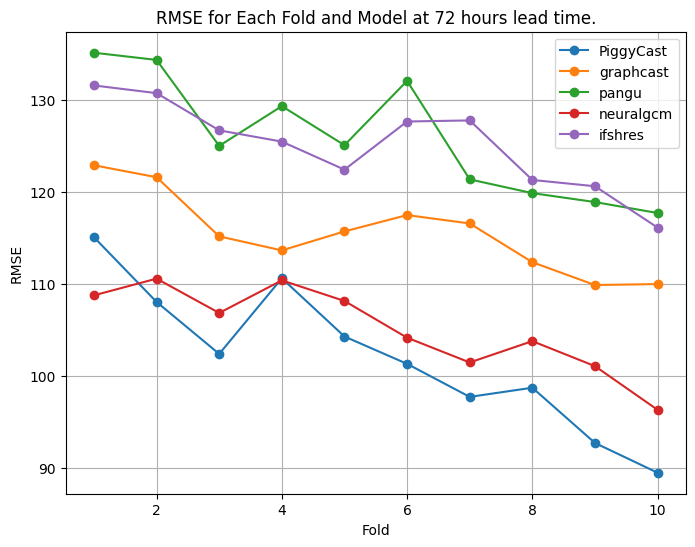

{48: {'PiggyCast': 64.1775584914425,
      'graphcast': 69.63800331707469,
      'ifshres': 74.18631782545808,
      'neuralgcm': 60.76147382469113,
      'pangu': 75.75723848328518},
 72: {'PiggyCast': 101.99432560939412,
      'graphcast': 115.48760779732575,
      'ifshres': 124.99237446580557,
      'neuralgcm': 105.10781897069894,
      'pangu': 125.83565063238966}}


In [ ]:
# @title Training and Evaluation Loop - Longer time series split: 60 days Training, 5 Days Gap and 30 Days Testing

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)

# Lead Times
lead_times=[48,72]
# lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]


nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)

  # print nicely average RMSE per Leadtime
  average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
  pprint(average_scores)



In [ ]:
import pandas as pd

# Parameters
n_samples = 1_497_088
n_splits = 10
max_train_size = 32 * 64 * 2 * 60  # 245,760
test_size = 32 * 64 * 2 * 30        # 122,880
gap = 32 * 64 * 2 * 5              # 20,480

# Calculate fold boundaries
folds = []
for i in range(n_splits):
    test_end = n_samples - (n_splits - 1 - i) * test_size
    test_start = test_end - test_size
    train_end = test_start - gap
    train_start = max(0, train_end - max_train_size)

    folds.append({
        "Fold": i + 1,
        "Train Start": train_start,
        "Train End": train_end - 1,
        "Gap Start": train_end,
        "Gap End": test_start - 1,
        "Test Start": test_start,
        "Test End": test_end - 1,
        "Train Size": train_end - train_start,
        "Test Size": test_size,
    })

# Convert to DataFrame
folds_df = pd.DataFrame(folds)
folds_df


,Fold,Train Start,Train End,Gap Start,Gap End,Test Start,Test End,Train Size,Test Size
0,1,2048,247807,247808,268287,268288,391167,245760,122880
1,2,124928,370687,370688,391167,391168,514047,245760,122880
2,3,247808,493567,493568,514047,514048,636927,245760,122880
3,4,370688,616447,616448,636927,636928,759807,245760,122880
4,5,493568,739327,739328,759807,759808,882687,245760,122880
5,6,616448,862207,862208,882687,882688,1005567,245760,122880
6,7,739328,985087,985088,1005567,1005568,1128447,245760,122880
7,8,862208,1107967,1107968,1128447,1128448,1251327,245760,122880
8,9,985088,1230847,1230848,1251327,1251328,1374207,245760,122880
9,10,1107968,1353727,1353728,1374207,1374208,1497087,245760,122880


======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-04 00:00:00 Train times Max Date:2020-01-17 12:00:00
Test times Min Date: 2020-01-19 00:00:00 Test times Max Date:2020-01-25 12:00:00
Train times Min Date: 2020-01-11 00:00:00 Train times Max Date:2020-01-24 12:00:00
Test times Min Date: 2020-01-26 00:00:00 Test times Max Date:2020-02-01 12:00:00
Train times Min Date: 2020-01-18 00:00:00 Train times Max Date:2020-01-31 12:00:00
Test times Min Date: 2020-02-02 00:00:00 Test times Max Date:2020-02-08 12:00:00
Train times Min Date: 2020-01-25 00:00:00 Train times Max Date:2020-02-07 12:00:00
Test times Min Date: 2020-02-09 00:00:00 Test times Max Date:2020-02-15 12:00:00
Train times Min Date: 2020-02-01 00:00:00 Train times Max Date:2020-02-14 12:00:00
Test times Min Date: 2020-02-16 00:00:00 Test times Max Date:2020-02-22 12:00:00
Train times Min Date: 2020-02-08 00:00:00 Train times Max Date:2020-02-21 12:00:00
Test times Min Date:

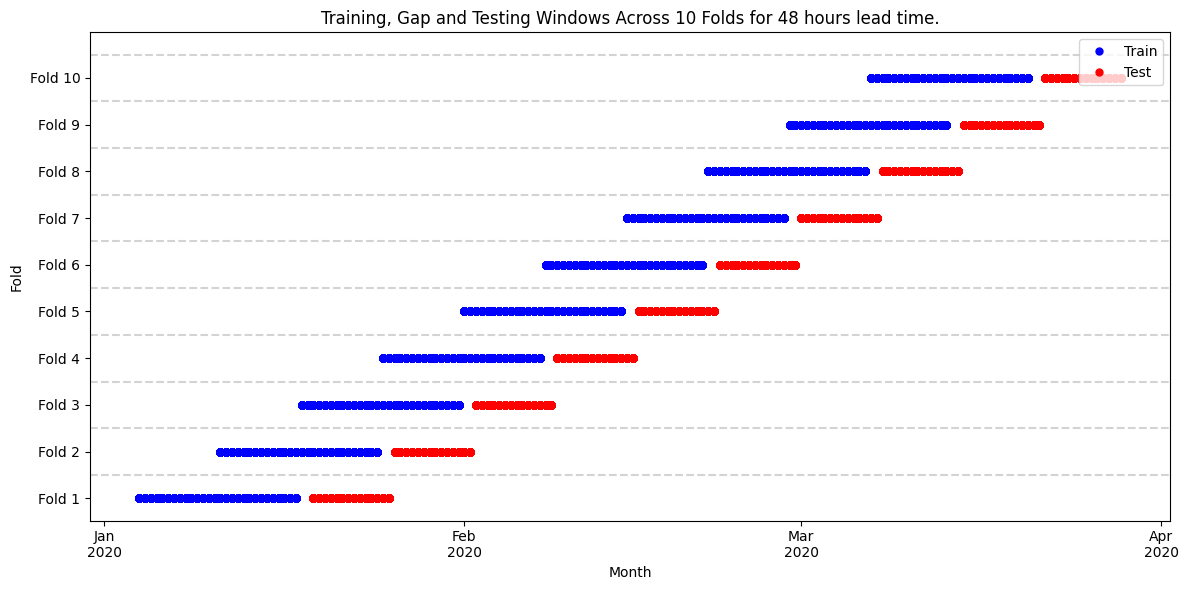

Fold 1:
  mse: 5451.60546875
  PiggyCast: area weighted rmse: 60.38548613455776
  graphcast: area weighted rmse: 66.20678638148297
  pangu: area weighted rmse: 73.25187701683323
  neuralgcm: area weighted rmse: 57.064416422694435
  ifshres: area weighted rmse: 73.25612433115195
Fold 2:
  mse: 8756.2548828125
  PiggyCast: area weighted rmse: 59.10154369781358
  graphcast: area weighted rmse: 67.18696932095679
  pangu: area weighted rmse: 75.6866919914812
  neuralgcm: area weighted rmse: 56.083009122549115
  ifshres: area weighted rmse: 76.64914821516122
Fold 3:
  mse: 8581.4501953125
  PiggyCast: area weighted rmse: 64.29598027667701
  graphcast: area weighted rmse: 72.90208568609224
  pangu: area weighted rmse: 78.45860350690234
  neuralgcm: area weighted rmse: 60.02047684968904
  ifshres: area weighted rmse: 77.68003396303061
Fold 4:
  mse: 7139.53466796875
  PiggyCast: area weighted rmse: 69.21239506587395
  graphcast: area weighted rmse: 74.00325104166043
  pangu: area weighted rmse

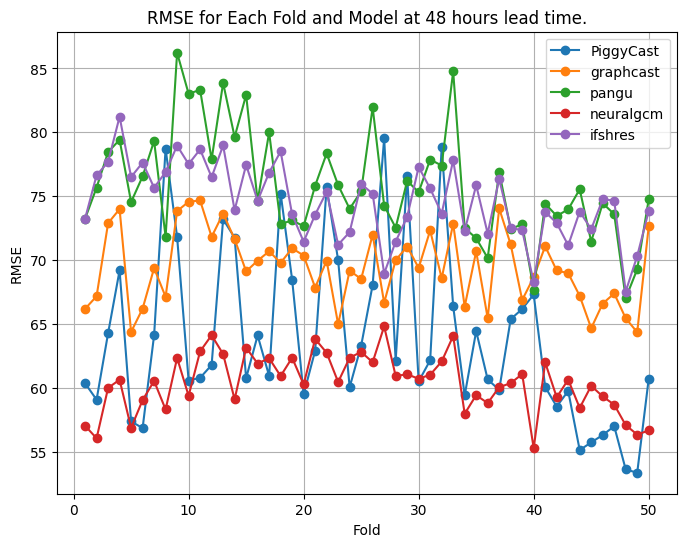

{48: {'PiggyCast': 63.99042361214641,
      'graphcast': 69.46556019429909,
      'ifshres': 74.58882984327866,
      'neuralgcm': 60.4314984922077,
      'pangu': 75.82875875527417}}
======Lead time: 72========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-05 00:00:00 Train times Max Date:2020-01-18 12:00:00
Test times Min Date: 2020-01-20 00:00:00 Test times Max Date:2020-01-26 12:00:00
Train times Min Date: 2020-01-12 00:00:00 Train times Max Date:2020-01-25 12:00:00
Test times Min Date: 2020-01-27 00:00:00 Test times Max Date:2020-02-02 12:00:00
Train times Min Date: 2020-01-19 00:00:00 Train times Max Date:2020-02-01 12:00:00
Test times Min Date: 2020-02-03 00:00:00 Test times Max Date:2020-02-09 12:00:00
Train times Min Date: 2020-01-26 00:00:00 Train times Max Date:2020-02-08 12:00:00
Test times Min Date: 2020-02-10 00:00:00 Test times Max Date:2020-02-16 12:00:00
Train times Min Date: 2020-02-02 00:00:00 Train times Max Date:2020-02-15 12:00:00


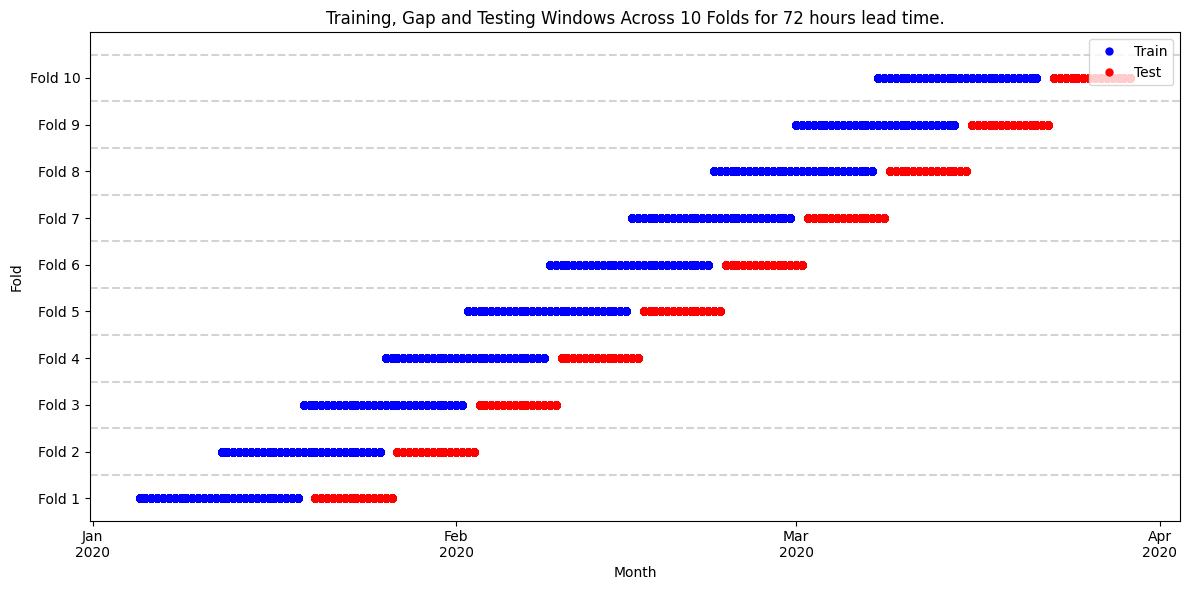

Fold 1:
  mse: 13016.232421875
  PiggyCast: area weighted rmse: 96.33054892869822
  graphcast: area weighted rmse: 112.36481517508207
  pangu: area weighted rmse: 119.76187380838239
  neuralgcm: area weighted rmse: 97.68319606121942
  ifshres: area weighted rmse: 118.25210902630512
Fold 2:
  mse: 18178.048828125
  PiggyCast: area weighted rmse: 96.14603791465345
  graphcast: area weighted rmse: 110.70637183928743
  pangu: area weighted rmse: 124.28262076397449
  neuralgcm: area weighted rmse: 97.10167278518675
  ifshres: area weighted rmse: 118.81238470397493
Fold 3:
  mse: 17498.583984375
  PiggyCast: area weighted rmse: 102.8934797979744
  graphcast: area weighted rmse: 121.9414270569667
  pangu: area weighted rmse: 130.6952533994007
  neuralgcm: area weighted rmse: 104.8456933216301
  ifshres: area weighted rmse: 126.06484559304855
Fold 4:
  mse: 15714.1650390625
  PiggyCast: area weighted rmse: 99.45221016873195
  graphcast: area weighted rmse: 119.86029705088232
  pangu: area weig

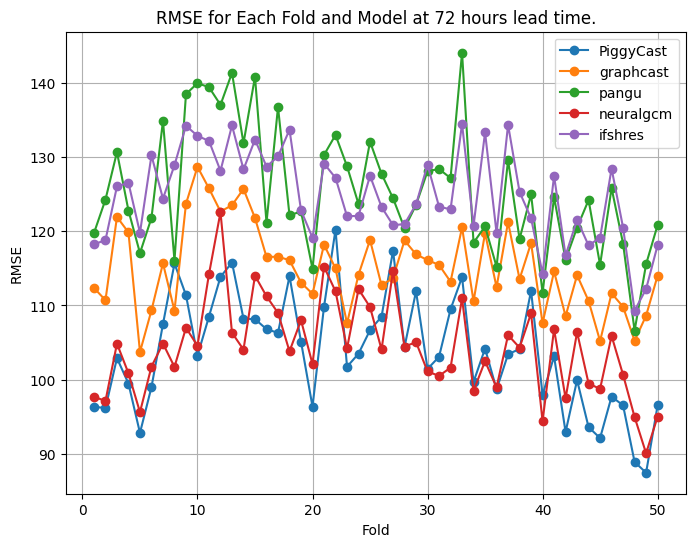

{48: {'PiggyCast': 63.99042361214641,
      'graphcast': 69.46556019429909,
      'ifshres': 74.58882984327866,
      'neuralgcm': 60.4314984922077,
      'pangu': 75.82875875527417},
 72: {'PiggyCast': 103.75844608396888,
      'graphcast': 115.11790194314993,
      'ifshres': 124.75959000338975,
      'neuralgcm': 104.3154221622194,
      'pangu': 125.48051701255454}}


In [ ]:
# @title Training and Evaluation Loop- Shorter Time series split: 2 Weeks Training, 1 Day Gap and 1 Week Testing

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=50, max_train_size=32 * 64 * 2 * 14,
                                test_size= 32 * 64 * 2 * 7, gap=32 * 64 * 2 * 1)

# Lead Times
lead_times=[48,72]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)

  # print nicely average RMSE per Leadtime
  average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
  pprint(average_scores)



In [ ]:
import pandas as pd

# Parameters
n_samples = 1_497_088
n_splits = 50
max_train_size = 32 * 64 * 2 * 14  # 57344
test_size = 32 * 64 * 2 * 7        # 28672
gap = 32 * 64 * 2 * 1              # 4096

# Calculate fold boundaries
folds = []
for i in range(n_splits):
    test_end = n_samples - (n_splits - 1 - i) * test_size
    test_start = test_end - test_size
    train_end = test_start - gap
    train_start = max(0, train_end - max_train_size)

    folds.append({
        "Fold": i + 1,
        "Train Start": train_start,
        "Train End": train_end - 1,
        "Gap Start": train_end,
        "Gap End": test_start - 1,
        "Test Start": test_start,
        "Test End": test_end - 1,
        "Train Size": train_end - train_start,
        "Test Size": test_size,
    })

# Convert to DataFrame
folds_df = pd.DataFrame(folds)
folds_df


,Fold,Train Start,Train End,Gap Start,Gap End,Test Start,Test End,Train Size,Test Size
0,1,2048,59391,59392,63487,63488,92159,57344,28672
1,2,30720,88063,88064,92159,92160,120831,57344,28672
2,3,59392,116735,116736,120831,120832,149503,57344,28672
3,4,88064,145407,145408,149503,149504,178175,57344,28672
4,5,116736,174079,174080,178175,178176,206847,57344,28672
5,6,145408,202751,202752,206847,206848,235519,57344,28672
6,7,174080,231423,231424,235519,235520,264191,57344,28672
7,8,202752,260095,260096,264191,264192,292863,57344,28672
8,9,231424,288767,288768,292863,292864,321535,57344,28672
9,10,260096,317439,317440,321535,321536,350207,57344,28672


======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-03-01 00:00:00 Train times Max Date:2020-03-07 12:00:00
Test times Min Date: 2020-03-09 00:00:00 Test times Max Date:2020-03-11 12:00:00
Train times Min Date: 2020-03-04 00:00:00 Train times Max Date:2020-03-10 12:00:00
Test times Min Date: 2020-03-12 00:00:00 Test times Max Date:2020-03-14 12:00:00
Train times Min Date: 2020-03-07 00:00:00 Train times Max Date:2020-03-13 12:00:00
Test times Min Date: 2020-03-15 00:00:00 Test times Max Date:2020-03-17 12:00:00
Train times Min Date: 2020-03-10 00:00:00 Train times Max Date:2020-03-16 12:00:00
Test times Min Date: 2020-03-18 00:00:00 Test times Max Date:2020-03-20 12:00:00
Train times Min Date: 2020-03-13 00:00:00 Train times Max Date:2020-03-19 12:00:00
Test times Min Date: 2020-03-21 00:00:00 Test times Max Date:2020-03-23 12:00:00
Train times Min Date: 2020-03-16 00:00:00 Train times Max Date:2020-03-22 12:00:00
Test times Min Date:

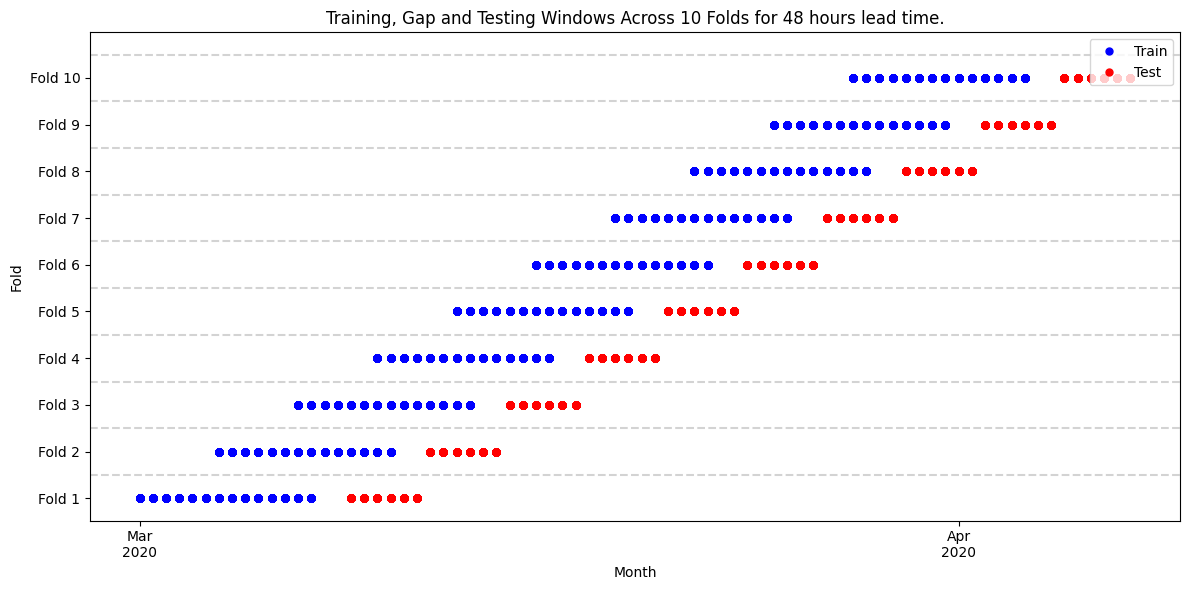

Fold 1:
  mse: 16026.4345703125
  PiggyCast: area weighted rmse: 67.07485118521454
  graphcast: area weighted rmse: 63.528116632048985
  pangu: area weighted rmse: 69.82623541730545
  neuralgcm: area weighted rmse: 57.39974159529101
  ifshres: area weighted rmse: 74.39076084663702
Fold 2:
  mse: 14905.6396484375
  PiggyCast: area weighted rmse: 72.55741444657635
  graphcast: area weighted rmse: 69.80057844348728
  pangu: area weighted rmse: 74.25513535024929
  neuralgcm: area weighted rmse: 60.208830053653486
  ifshres: area weighted rmse: 75.74934514322473
Fold 3:
  mse: 8128.06884765625
  PiggyCast: area weighted rmse: 65.56141705181754
  graphcast: area weighted rmse: 73.86376538360258
  pangu: area weighted rmse: 87.67624380260702
  neuralgcm: area weighted rmse: 62.76349023693254
  ifshres: area weighted rmse: 78.28435169632229
Fold 4:
  mse: 10371.9794921875
  PiggyCast: area weighted rmse: 72.74297567405281
  graphcast: area weighted rmse: 73.29789206148082
  pangu: area weighte

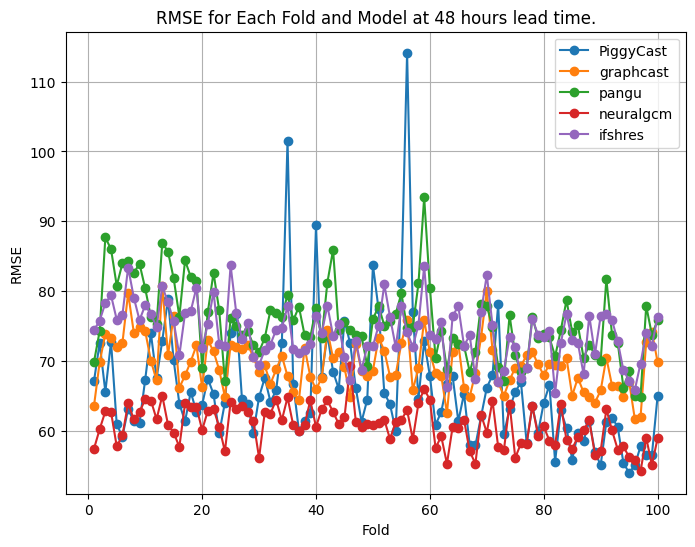

{48: {'PiggyCast': 65.98529662326521,
      'graphcast': 69.5591285985073,
      'ifshres': 74.10824446618233,
      'neuralgcm': 60.71513398370254,
      'pangu': 75.6399261334173}}
======Lead time: 72========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-03-02 00:00:00 Train times Max Date:2020-03-08 12:00:00
Test times Min Date: 2020-03-10 00:00:00 Test times Max Date:2020-03-12 12:00:00
Train times Min Date: 2020-03-05 00:00:00 Train times Max Date:2020-03-11 12:00:00
Test times Min Date: 2020-03-13 00:00:00 Test times Max Date:2020-03-15 12:00:00
Train times Min Date: 2020-03-08 00:00:00 Train times Max Date:2020-03-14 12:00:00
Test times Min Date: 2020-03-16 00:00:00 Test times Max Date:2020-03-18 12:00:00
Train times Min Date: 2020-03-11 00:00:00 Train times Max Date:2020-03-17 12:00:00
Test times Min Date: 2020-03-19 00:00:00 Test times Max Date:2020-03-21 12:00:00
Train times Min Date: 2020-03-14 00:00:00 Train times Max Date:2020-03-20 12:00:00
T

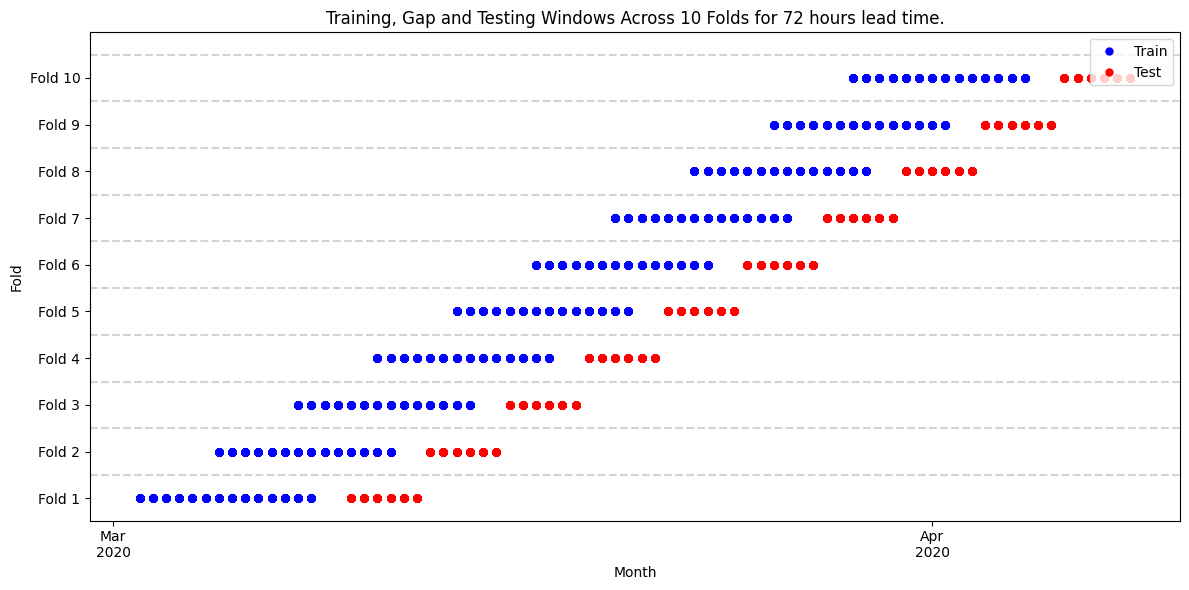

Fold 1:
  mse: 27935.09375
  PiggyCast: area weighted rmse: 104.92545247266249
  graphcast: area weighted rmse: 102.3768425748744
  pangu: area weighted rmse: 111.85332065676496
  neuralgcm: area weighted rmse: 94.53941177586162
  ifshres: area weighted rmse: 119.20425523289474
Fold 2:
  mse: 24427.0
  PiggyCast: area weighted rmse: 108.5597913356762
  graphcast: area weighted rmse: 116.18889892256601
  pangu: area weighted rmse: 120.60965236675537
  neuralgcm: area weighted rmse: 111.9551915082939
  ifshres: area weighted rmse: 134.10029250653756
Fold 3:
  mse: 18510.287109375
  PiggyCast: area weighted rmse: 105.7651830212297
  graphcast: area weighted rmse: 115.53644171872448
  pangu: area weighted rmse: 134.10771035214867
  neuralgcm: area weighted rmse: 107.55901759636853
  ifshres: area weighted rmse: 130.0567107445908
Fold 4:
  mse: 20507.740234375
  PiggyCast: area weighted rmse: 113.25733133790311
  graphcast: area weighted rmse: 129.4140278689898
  pangu: area weighted rmse: 

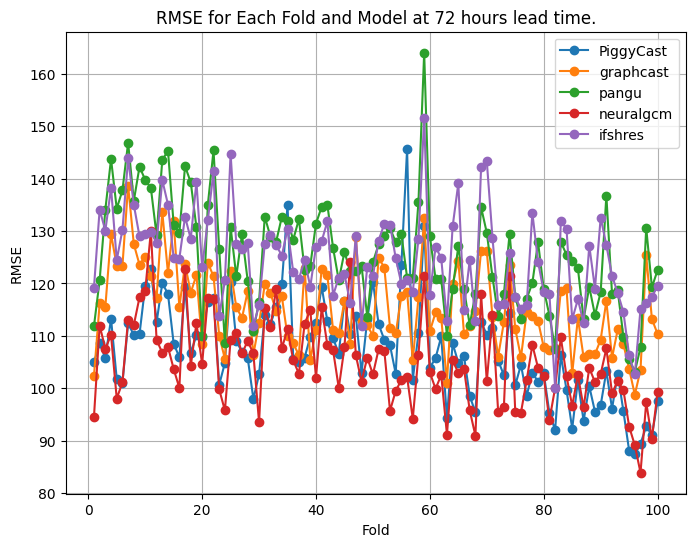

{48: {'PiggyCast': 65.98529662326521,
      'graphcast': 69.5591285985073,
      'ifshres': 74.10824446618233,
      'neuralgcm': 60.71513398370254,
      'pangu': 75.6399261334173},
 72: {'PiggyCast': 107.21741652664775,
      'graphcast': 115.28758890059464,
      'ifshres': 124.74234192251387,
      'neuralgcm': 104.86569368856097,
      'pangu': 125.55108112413224}}


In [ ]:
# @title Training and Evaluation Loop- Shorter Time series split : 1 Weeks Training, 1 Day Gap and 3 Days Testing

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=100, max_train_size=32 * 64 * 2 * 7,
                                test_size= 32 * 64 * 2 * 3, gap=32 * 64 * 2 * 1)

# Lead Times
lead_times=[48, 72]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)

  # print nicely average RMSE per Leadtime
  average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
  pprint(average_scores)



======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-09-22 00:00:00 Train times Max Date:2020-09-23 12:00:00
Test times Min Date: 2020-09-25 00:00:00 Test times Max Date:2020-09-25 12:00:00
Train times Min Date: 2020-09-23 00:00:00 Train times Max Date:2020-09-24 12:00:00
Test times Min Date: 2020-09-26 00:00:00 Test times Max Date:2020-09-26 12:00:00
Train times Min Date: 2020-09-24 00:00:00 Train times Max Date:2020-09-25 12:00:00
Test times Min Date: 2020-09-27 00:00:00 Test times Max Date:2020-09-27 12:00:00
Train times Min Date: 2020-09-25 00:00:00 Train times Max Date:2020-09-26 12:00:00
Test times Min Date: 2020-09-28 00:00:00 Test times Max Date:2020-09-28 12:00:00
Train times Min Date: 2020-09-26 00:00:00 Train times Max Date:2020-09-27 12:00:00
Test times Min Date: 2020-09-29 00:00:00 Test times Max Date:2020-09-29 12:00:00
Train times Min Date: 2020-09-27 00:00:00 Train times Max Date:2020-09-28 12:00:00
Test times Min Date:

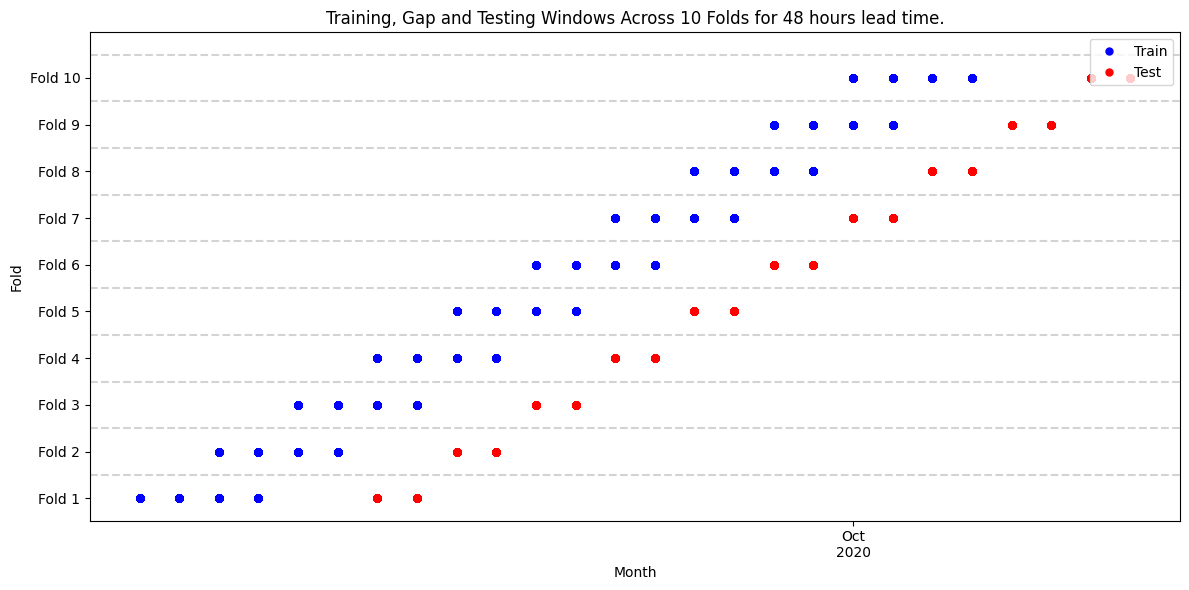

Fold 1:
  mse: 6579.8681640625
  PiggyCast: area weighted rmse: 64.27715679022232
  graphcast: area weighted rmse: 64.7010507857331
  pangu: area weighted rmse: 71.67007657862156
  neuralgcm: area weighted rmse: 54.47844189779927
  ifshres: area weighted rmse: 67.13785716861318
Fold 2:
  mse: 6050.3388671875
  PiggyCast: area weighted rmse: 61.815750069569944
  graphcast: area weighted rmse: 65.17185658519556
  pangu: area weighted rmse: 69.3021205102403
  neuralgcm: area weighted rmse: 55.61175656862767
  ifshres: area weighted rmse: 66.92234443677067
Fold 3:
  mse: 6642.29345703125
  PiggyCast: area weighted rmse: 63.148121163809755
  graphcast: area weighted rmse: 73.20989381522514
  pangu: area weighted rmse: 72.29347322768889
  neuralgcm: area weighted rmse: 57.49600666149801
  ifshres: area weighted rmse: 67.07044365455289
Fold 4:
  mse: 5614.4189453125
  PiggyCast: area weighted rmse: 56.68667754955649
  graphcast: area weighted rmse: 66.15612655157008
  pangu: area weighted rms

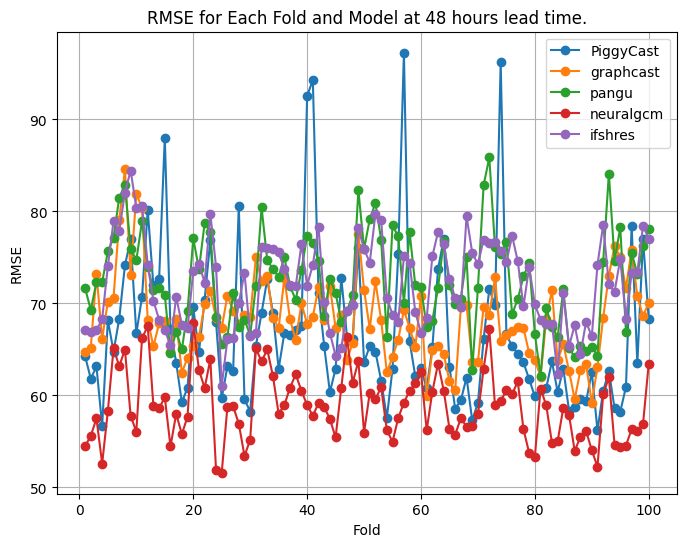

{48: {'PiggyCast': 66.79803191395125,
      'graphcast': 68.30286540686531,
      'ifshres': 72.26321581642165,
      'neuralgcm': 58.8188866450093,
      'pangu': 72.53779305424568}}
======Lead time: 72========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-09-23 00:00:00 Train times Max Date:2020-09-24 12:00:00
Test times Min Date: 2020-09-26 00:00:00 Test times Max Date:2020-09-26 12:00:00
Train times Min Date: 2020-09-24 00:00:00 Train times Max Date:2020-09-25 12:00:00
Test times Min Date: 2020-09-27 00:00:00 Test times Max Date:2020-09-27 12:00:00
Train times Min Date: 2020-09-25 00:00:00 Train times Max Date:2020-09-26 12:00:00
Test times Min Date: 2020-09-28 00:00:00 Test times Max Date:2020-09-28 12:00:00
Train times Min Date: 2020-09-26 00:00:00 Train times Max Date:2020-09-27 12:00:00
Test times Min Date: 2020-09-29 00:00:00 Test times Max Date:2020-09-29 12:00:00
Train times Min Date: 2020-09-27 00:00:00 Train times Max Date:2020-09-28 12:00:00


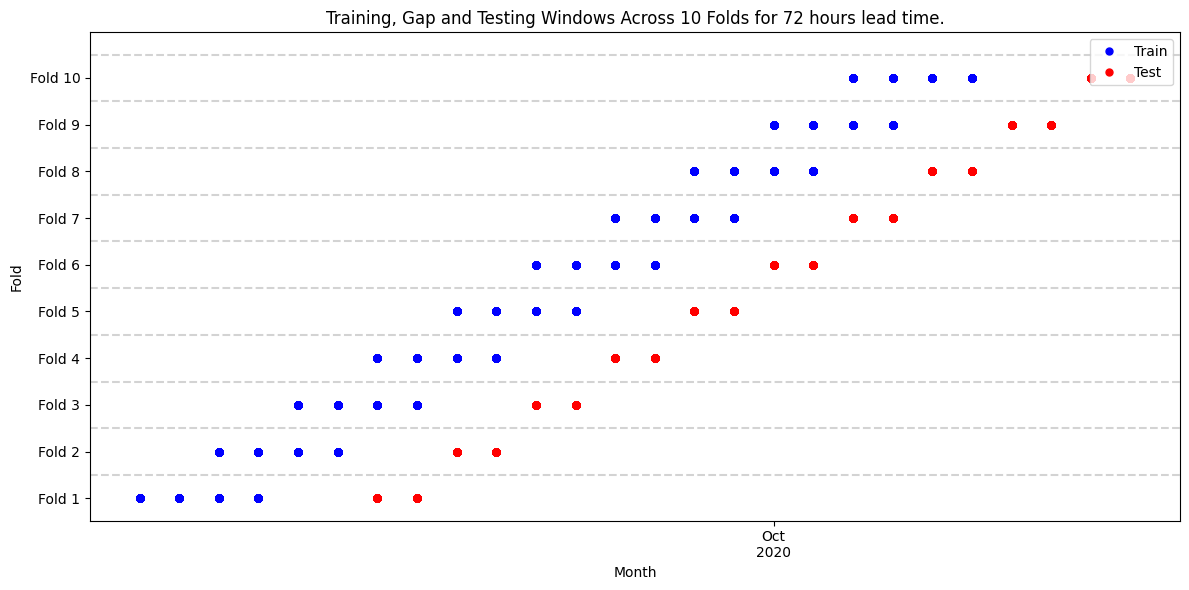

Fold 1:
  mse: 15203.7177734375
  PiggyCast: area weighted rmse: 102.50044061264526
  graphcast: area weighted rmse: 108.7601001129764
  pangu: area weighted rmse: 112.44280801177455
  neuralgcm: area weighted rmse: 94.7277400650581
  ifshres: area weighted rmse: 119.57172113688648
Fold 2:
  mse: 16697.625
  PiggyCast: area weighted rmse: 103.58549890534623
  graphcast: area weighted rmse: 120.20289383553995
  pangu: area weighted rmse: 113.38236504066295
  neuralgcm: area weighted rmse: 93.52006649882571
  ifshres: area weighted rmse: 119.40931479315795
Fold 3:
  mse: 14977.623046875
  PiggyCast: area weighted rmse: 96.26460875840236
  graphcast: area weighted rmse: 117.55231146795376
  pangu: area weighted rmse: 113.50826041142932
  neuralgcm: area weighted rmse: 91.19467353444057
  ifshres: area weighted rmse: 106.09490251424012
Fold 4:
  mse: 18255.123046875
  PiggyCast: area weighted rmse: 100.90601141997594
  graphcast: area weighted rmse: 106.20874122673901
  pangu: area weighte

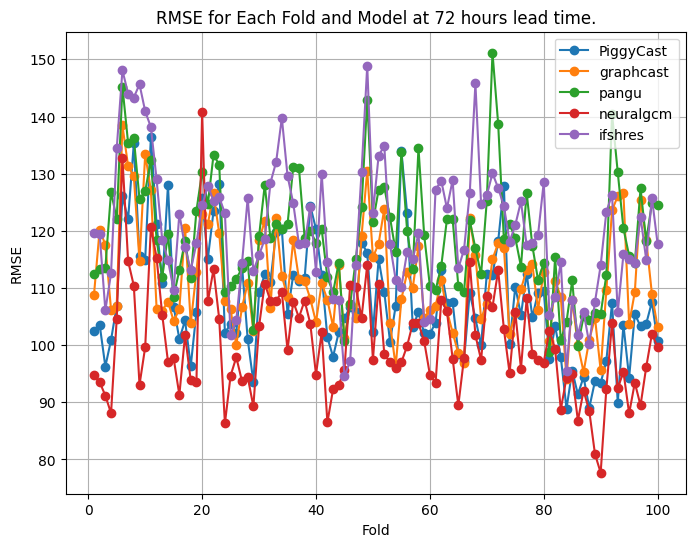

{48: {'PiggyCast': 66.79803191395125,
      'graphcast': 68.30286540686531,
      'ifshres': 72.26321581642165,
      'neuralgcm': 58.8188866450093,
      'pangu': 72.53779305424568},
 72: {'PiggyCast': 107.94384671656853,
      'graphcast': 111.42913152151061,
      'ifshres': 120.12220493594052,
      'neuralgcm': 100.2072524465265,
      'pangu': 119.10993731096305}}


In [ ]:
# @title Training and Evaluation Loop- Shorter Time series split : 2 Days Training, 1 Day Gap and 1 Day Testing

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=100, max_train_size=32 * 64 * 2 * 2,
                                test_size= 32 * 64 * 2 * 1, gap=32 * 64 * 2 * 1)

# Lead Times
lead_times=[48, 72]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)

  # print nicely average RMSE per Leadtime
  average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
  pprint(average_scores)



======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:23:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Train times Min Date: 2020-09-14 00:00:00 Train times Max Date:2020-11-12 12:00:00
Test times Min Date: 2020-11-14 00:00:00 Test times Max Date:2020-11-14 12:00:00
Train times Min Date: 2020-09-15 00:00:00 Train times Max Date:2020-11-13 12:00:00
Test times Min Date: 2020-11-15 00:00:00 Test times Max Date:2020-11-15 12:00:00
Train times Min Date: 2020-09-16 00:00:00 Train times Max Date:2020-11-14 12:00:00
Test times Min Date: 2020-11-16 00:00:00 Test times Max Date:2020-11-16 12:00:00
Train times Min Date: 2020-09-17 00:00:00 Train times Max Date:2020-11-15 12:00:00
Test times Min Date: 2020-11-17 00:00:00 Test times Max Date:2020-11-17 12:00:00
Train times Min Date: 2020-09-18 00:00:00 Train times Max Date:2020-11-16 12:00:00
Test times Min Date: 2020-11-18 00:00:00 Test times Max Date:2020-11-18 12:00:00
Train times Min Date: 2020-09-19 00:00:00 Train times Max Date:2020-11-17 12:00:00
Test times Min Date: 2020-11-19 00:00:00 Test times Max Date:2020-11-19 12:00:00
Train times Min 

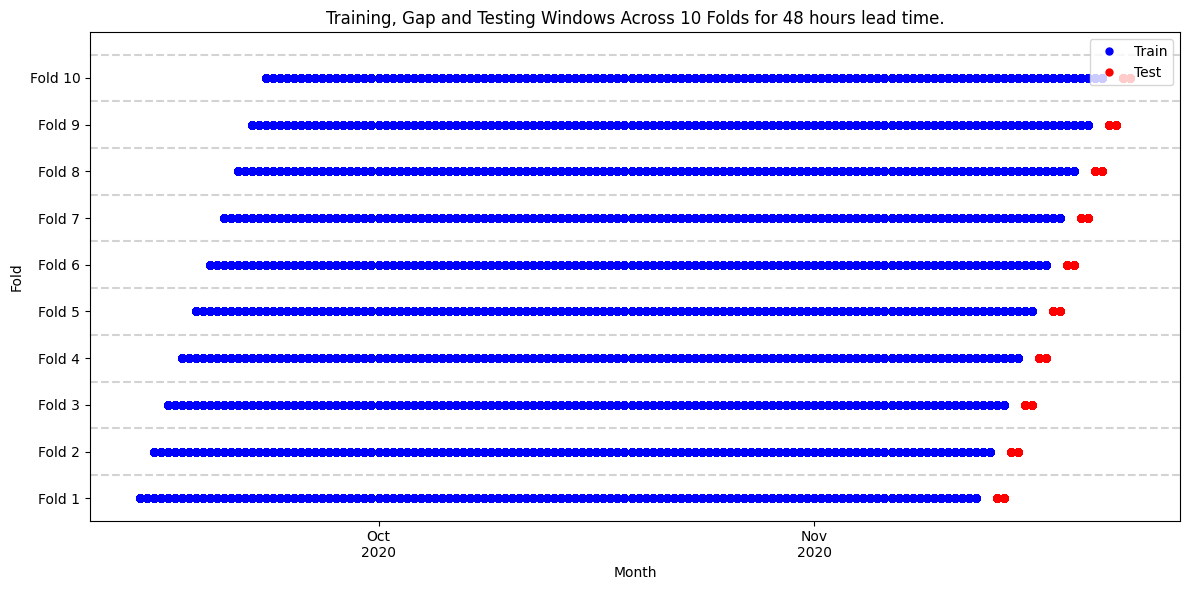

Fold 1:
  mse: 4568.5498046875
  PiggyCast: area weighted rmse: 55.715367462108254
  graphcast: area weighted rmse: 67.26584189280081
  pangu: area weighted rmse: 79.14576529735893
  neuralgcm: area weighted rmse: 60.28657172531705
  ifshres: area weighted rmse: 74.44224470999734
Fold 2:
  mse: 4854.421875
  PiggyCast: area weighted rmse: 58.37261338156236
  graphcast: area weighted rmse: 72.38865764918006
  pangu: area weighted rmse: 80.92375255983762
  neuralgcm: area weighted rmse: 59.581779657256625
  ifshres: area weighted rmse: 79.7550172093289
Fold 3:
  mse: 4516.255859375
  PiggyCast: area weighted rmse: 56.61145340536326
  graphcast: area weighted rmse: 68.19580830057947
  pangu: area weighted rmse: 76.94252000249926
  neuralgcm: area weighted rmse: 60.911534441497196
  ifshres: area weighted rmse: 79.08546032051333
Fold 4:
  mse: 3737.99072265625
  PiggyCast: area weighted rmse: 50.796521191390504
  graphcast: area weighted rmse: 62.53395595099651
  pangu: area weighted rmse:

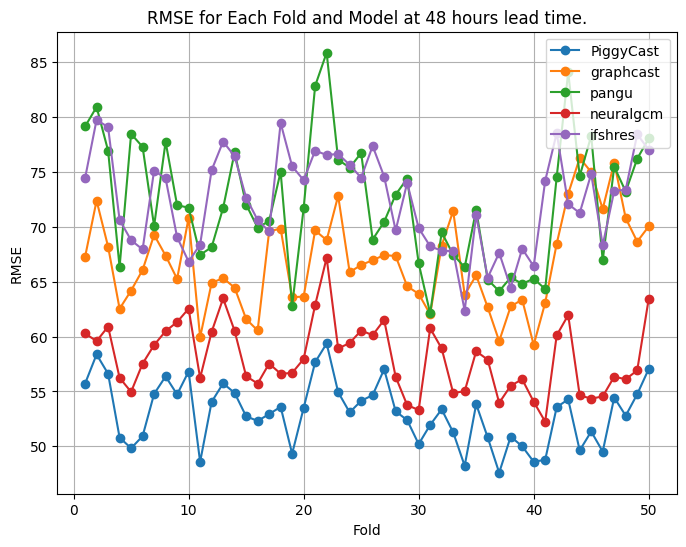

{48: {'PiggyCast': 53.03694621942815,
      'graphcast': 66.84430781450041,
      'ifshres': 72.4432374143341,
      'neuralgcm': 58.10042924859443,
      'pangu': 72.28982916835817}}
======Lead time: 72========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-09-15 00:00:00 Train times Max Date:2020-11-13 12:00:00
Test times Min Date: 2020-11-15 00:00:00 Test times Max Date:2020-11-15 12:00:00
Train times Min Date: 2020-09-16 00:00:00 Train times Max Date:2020-11-14 12:00:00
Test times Min Date: 2020-11-16 00:00:00 Test times Max Date:2020-11-16 12:00:00
Train times Min Date: 2020-09-17 00:00:00 Train times Max Date:2020-11-15 12:00:00
Test times Min Date: 2020-11-17 00:00:00 Test times Max Date:2020-11-17 12:00:00
Train times Min Date: 2020-09-18 00:00:00 Train times Max Date:2020-11-16 12:00:00
Test times Min Date: 2020-11-18 00:00:00 Test times Max Date:2020-11-18 12:00:00
Train times Min Date: 2020-09-19 00:00:00 Train times Max Date:2020-11-17 12:00:00


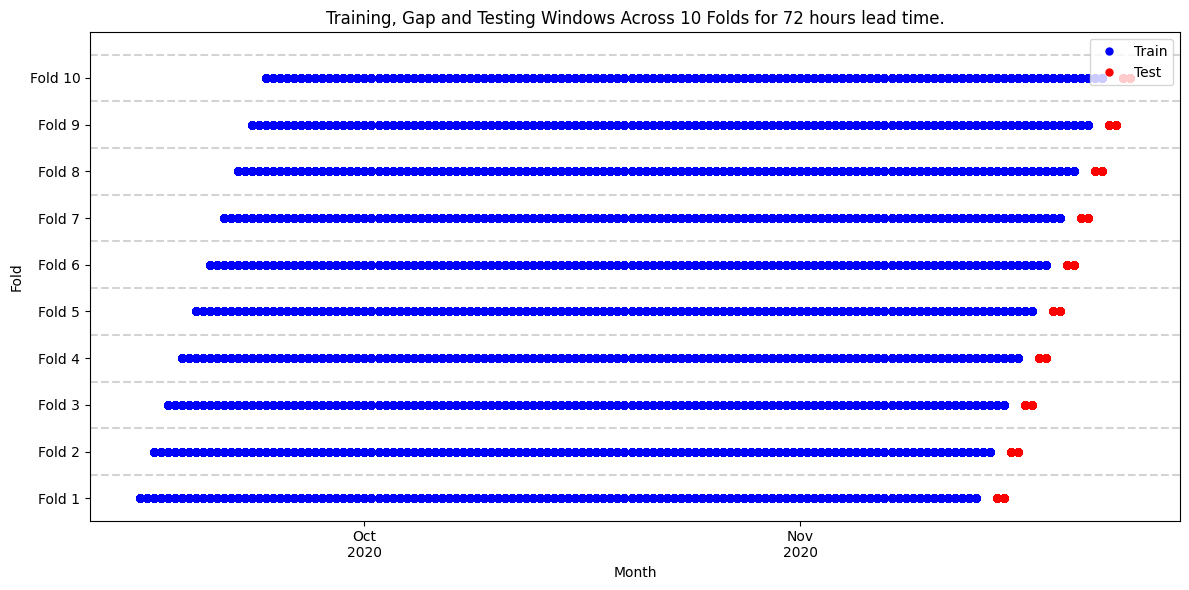

Fold 1:
  mse: 15209.384765625
  PiggyCast: area weighted rmse: 101.7729988943827
  graphcast: area weighted rmse: 117.77855016572933
  pangu: area weighted rmse: 127.2145172609764
  neuralgcm: area weighted rmse: 110.62484092956555
  ifshres: area weighted rmse: 133.17765603651384
Fold 2:
  mse: 14454.0849609375
  PiggyCast: area weighted rmse: 97.01946013096051
  graphcast: area weighted rmse: 123.88308762160507
  pangu: area weighted rmse: 127.64664422176315
  neuralgcm: area weighted rmse: 98.41864908680438
  ifshres: area weighted rmse: 134.8304905145069
Fold 3:
  mse: 11714.0625
  PiggyCast: area weighted rmse: 89.29832402124414
  graphcast: area weighted rmse: 103.8420001129641
  pangu: area weighted rmse: 122.3343213036534
  neuralgcm: area weighted rmse: 96.99854007363491
  ifshres: area weighted rmse: 117.6502625276291
Fold 4:
  mse: 9819.94140625
  PiggyCast: area weighted rmse: 80.94750412824678
  graphcast: area weighted rmse: 96.26465298294372
  pangu: area weighted rmse:

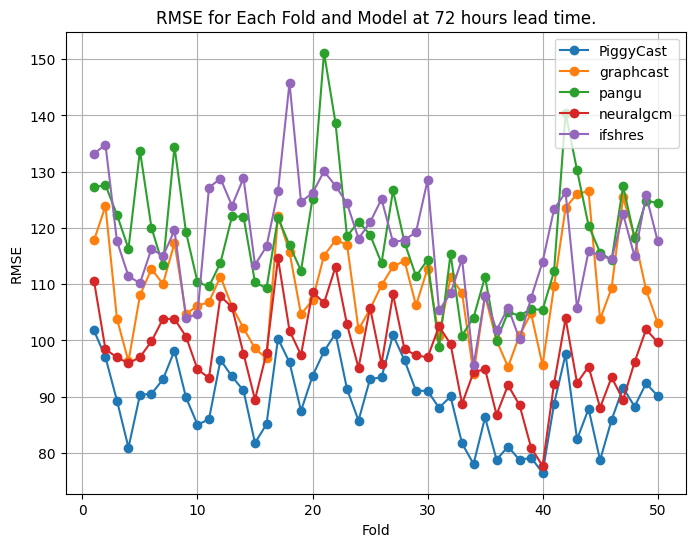

{48: {'PiggyCast': 53.03694621942815,
      'graphcast': 66.84430781450041,
      'ifshres': 72.4432374143341,
      'neuralgcm': 58.10042924859443,
      'pangu': 72.28982916835817},
 72: {'PiggyCast': 89.4396219230353,
      'graphcast': 109.19664431513249,
      'ifshres': 118.02268477818927,
      'neuralgcm': 97.9078312509262,
      'pangu': 117.98457277474706}}


In [ ]:
# @title Training and Evaluation Loop- Time series split : 60 Days Training, 1 Day Gap and 1 Day Testing

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=50, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 1, gap=32 * 64 * 2 * 1)

# Lead Times
lead_times=[48, 72]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)

  # print nicely average RMSE per Leadtime
  average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
  pprint(average_scores)



======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:13:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Train times Min Date: 2020-01-03 12:00:00 Train times Max Date:2020-01-15 12:00:00
Test times Min Date: 2020-01-19 00:00:00 Test times Max Date:2020-01-25 12:00:00
Train times Min Date: 2020-01-03 12:00:00 Train times Max Date:2020-01-22 12:00:00
Test times Min Date: 2020-01-26 00:00:00 Test times Max Date:2020-02-01 12:00:00
Train times Min Date: 2020-01-03 12:00:00 Train times Max Date:2020-01-29 12:00:00
Test times Min Date: 2020-02-02 00:00:00 Test times Max Date:2020-02-08 12:00:00
Train times Min Date: 2020-01-03 12:00:00 Train times Max Date:2020-02-05 12:00:00
Test times Min Date: 2020-02-09 00:00:00 Test times Max Date:2020-02-15 12:00:00
Train times Min Date: 2020-01-03 12:00:00 Train times Max Date:2020-02-12 12:00:00
Test times Min Date: 2020-02-16 00:00:00 Test times Max Date:2020-02-22 12:00:00
Train times Min Date: 2020-01-03 12:00:00 Train times Max Date:2020-02-19 12:00:00
Test times Min Date: 2020-02-23 00:00:00 Test times Max Date:2020-02-29 12:00:00
Train times Min 

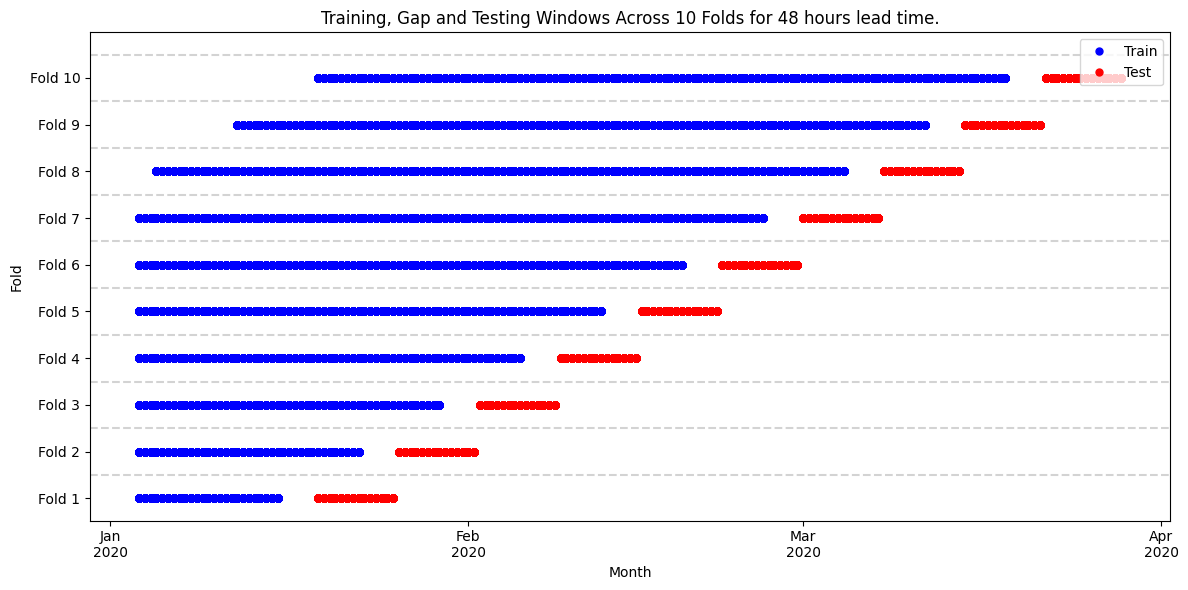

Fold 1:
  mse: 5410.84130859375
  PiggyCast: area weighted rmse: 60.47860613298887
  graphcast: area weighted rmse: 66.20678638148297
  pangu: area weighted rmse: 73.25187701683323
  neuralgcm: area weighted rmse: 57.064416422694435
  ifshres: area weighted rmse: 73.25612433115195
Fold 2:
  mse: 6655.94091796875
  PiggyCast: area weighted rmse: 56.71209859961531
  graphcast: area weighted rmse: 67.18696932095679
  pangu: area weighted rmse: 75.6866919914812
  neuralgcm: area weighted rmse: 56.083009122549115
  ifshres: area weighted rmse: 76.64914821516122
Fold 3:
  mse: 7962.8212890625
  PiggyCast: area weighted rmse: 61.35252082679142
  graphcast: area weighted rmse: 72.90208568609224
  pangu: area weighted rmse: 78.45860350690234
  neuralgcm: area weighted rmse: 60.02047684968904
  ifshres: area weighted rmse: 77.68003396303061
Fold 4:
  mse: 6079.57666015625
  PiggyCast: area weighted rmse: 63.95967002516803
  graphcast: area weighted rmse: 74.00325104166043
  pangu: area weighted 

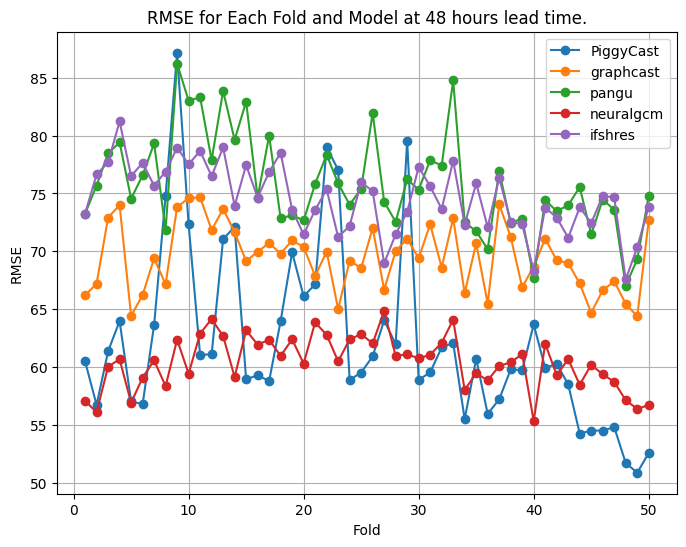

{48: {'PiggyCast': 62.21914826449831,
      'graphcast': 69.46556019429909,
      'ifshres': 74.58882984327866,
      'neuralgcm': 60.4314984922077,
      'pangu': 75.82875875527417}}
======Lead time: 72========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-04 12:00:00 Train times Max Date:2020-01-16 12:00:00
Test times Min Date: 2020-01-20 00:00:00 Test times Max Date:2020-01-26 12:00:00
Train times Min Date: 2020-01-04 12:00:00 Train times Max Date:2020-01-23 12:00:00
Test times Min Date: 2020-01-27 00:00:00 Test times Max Date:2020-02-02 12:00:00
Train times Min Date: 2020-01-04 12:00:00 Train times Max Date:2020-01-30 12:00:00
Test times Min Date: 2020-02-03 00:00:00 Test times Max Date:2020-02-09 12:00:00
Train times Min Date: 2020-01-04 12:00:00 Train times Max Date:2020-02-06 12:00:00
Test times Min Date: 2020-02-10 00:00:00 Test times Max Date:2020-02-16 12:00:00
Train times Min Date: 2020-01-04 12:00:00 Train times Max Date:2020-02-13 12:00:00


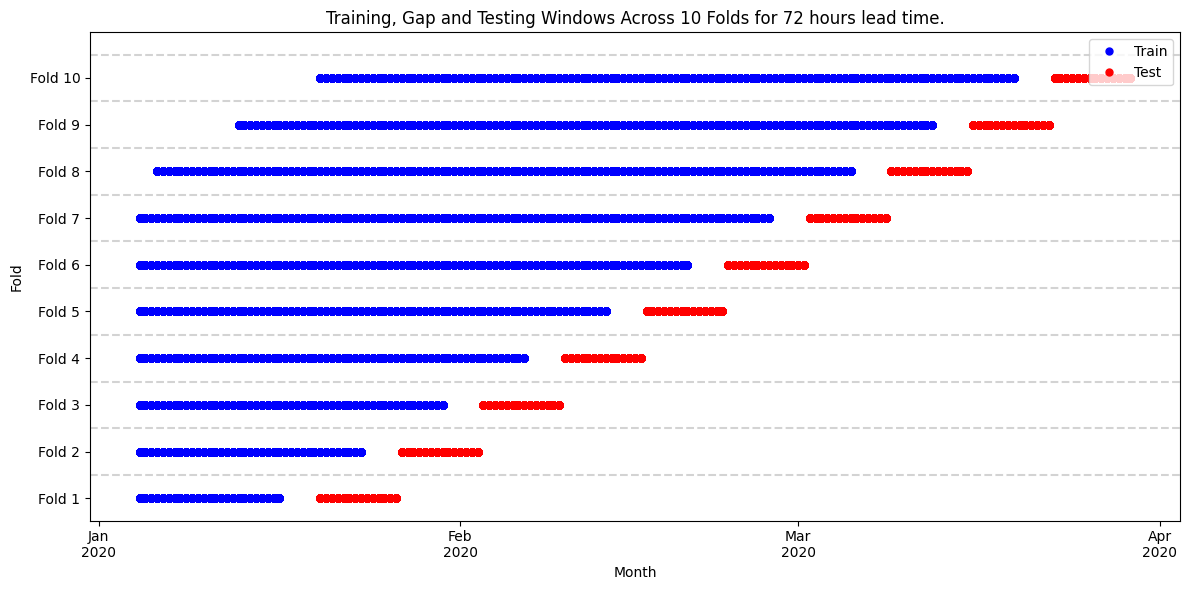

Fold 1:
  mse: 13093.9765625
  PiggyCast: area weighted rmse: 96.8329200482463
  graphcast: area weighted rmse: 112.36481517508207
  pangu: area weighted rmse: 119.76187380838239
  neuralgcm: area weighted rmse: 97.68319606121942
  ifshres: area weighted rmse: 118.25210902630512
Fold 2:
  mse: 15869.9189453125
  PiggyCast: area weighted rmse: 94.70867977929811
  graphcast: area weighted rmse: 110.70637183928743
  pangu: area weighted rmse: 124.28262076397449
  neuralgcm: area weighted rmse: 97.10167278518675
  ifshres: area weighted rmse: 118.81238470397493
Fold 3:
  mse: 15190.1884765625
  PiggyCast: area weighted rmse: 99.13470408326185
  graphcast: area weighted rmse: 121.9414270569667
  pangu: area weighted rmse: 130.6952533994007
  neuralgcm: area weighted rmse: 104.8456933216301
  ifshres: area weighted rmse: 126.06484559304855
Fold 4:
  mse: 14930.7607421875
  PiggyCast: area weighted rmse: 98.43156512218657
  graphcast: area weighted rmse: 119.86029705088232
  pangu: area weigh

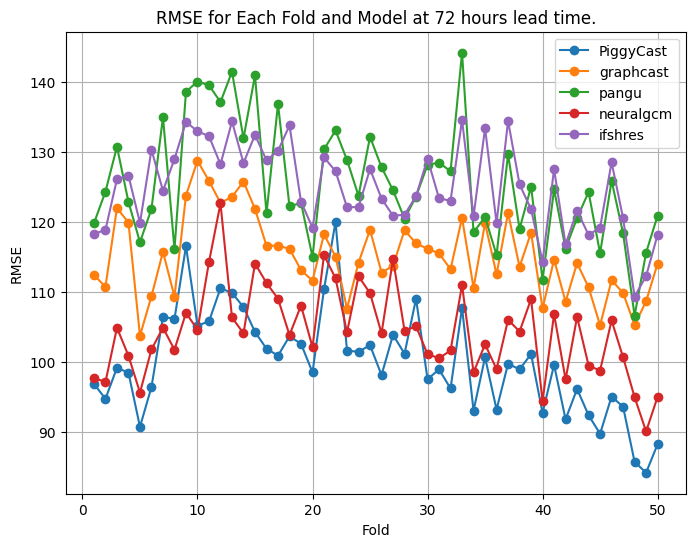

{48: {'PiggyCast': 62.21914826449831,
      'graphcast': 69.46556019429909,
      'ifshres': 74.58882984327866,
      'neuralgcm': 60.4314984922077,
      'pangu': 75.82875875527417},
 72: {'PiggyCast': 99.98607898625964,
      'graphcast': 115.11790194314993,
      'ifshres': 124.75959000338975,
      'neuralgcm': 104.3154221622194,
      'pangu': 125.48051701255454}}


In [12]:
# @title Training and Evaluation Loop- Time series split : 60 Days Training, 3 Day Gap and  7 Days Testing

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=50, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 7, gap=32 * 64 * 2 * 3)

# Lead Times
lead_times=[48, 72]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)

  # print nicely average RMSE per Leadtime
  average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
  pprint(average_scores)



======Lead time: 48========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-26 00:00:00 Train times Max Date:2020-03-25 12:00:00
Test times Min Date: 2020-03-29 00:00:00 Test times Max Date:2020-04-11 12:00:00
Train times Min Date: 2020-02-09 00:00:00 Train times Max Date:2020-04-08 12:00:00
Test times Min Date: 2020-04-12 00:00:00 Test times Max Date:2020-04-25 12:00:00
Train times Min Date: 2020-02-23 00:00:00 Train times Max Date:2020-04-22 12:00:00
Test times Min Date: 2020-04-26 00:00:00 Test times Max Date:2020-05-09 12:00:00
Train times Min Date: 2020-03-08 00:00:00 Train times Max Date:2020-05-06 12:00:00
Test times Min Date: 2020-05-10 00:00:00 Test times Max Date:2020-05-23 12:00:00
Train times Min Date: 2020-03-22 00:00:00 Train times Max Date:2020-05-20 12:00:00
Test times Min Date: 2020-05-24 00:00:00 Test times Max Date:2020-06-06 12:00:00
Train times Min Date: 2020-04-05 00:00:00 Train times Max Date:2020-06-03 12:00:00
Test times Min Date:

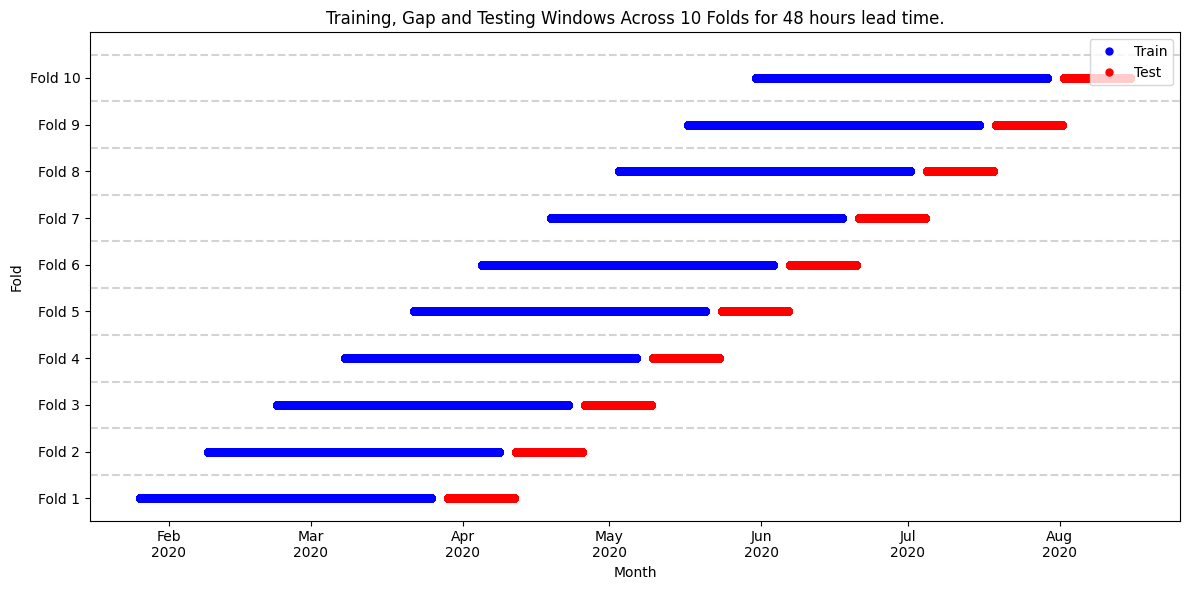

Fold 1:
  mse: 5804.4599609375
  PiggyCast: area weighted rmse: 61.718955981983356
  graphcast: area weighted rmse: 73.26967257115749
  pangu: area weighted rmse: 80.64946444297773
  neuralgcm: area weighted rmse: 63.51443718492743
  ifshres: area weighted rmse: 77.59091040500961
Fold 2:
  mse: 13222.6240234375
  PiggyCast: area weighted rmse: 74.1288496331018
  graphcast: area weighted rmse: 72.66352481670117
  pangu: area weighted rmse: 81.77676507528979
  neuralgcm: area weighted rmse: 60.92429963302961
  ifshres: area weighted rmse: 76.49096788257647
Fold 3:
  mse: 5668.515625
  PiggyCast: area weighted rmse: 59.35307086218736
  graphcast: area weighted rmse: 69.55253602397016
  pangu: area weighted rmse: 78.89377789319788
  neuralgcm: area weighted rmse: 62.5520480746315
  ifshres: area weighted rmse: 76.06622284788064
Fold 4:
  mse: 6443.7490234375
  PiggyCast: area weighted rmse: 61.45721206943577
  graphcast: area weighted rmse: 70.25378990590347
  pangu: area weighted rmse: 76

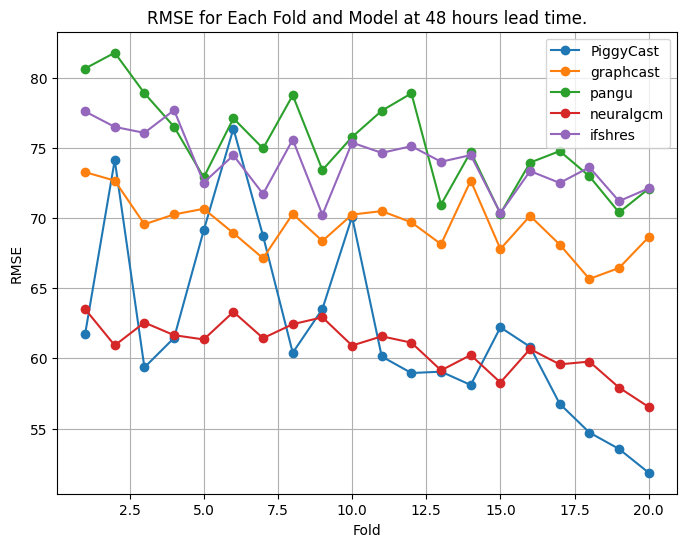

{48: {'PiggyCast': 62.051274579764254,
      'graphcast': 69.45674309067948,
      'ifshres': 73.9548889995106,
      'neuralgcm': 60.79122487980245,
      'pangu': 75.36892184002714}}
======Lead time: 72========
Shape of x :(1497088, 6)
Shape of y : (1497088,)
Train times Min Date: 2020-01-27 00:00:00 Train times Max Date:2020-03-26 12:00:00
Test times Min Date: 2020-03-30 00:00:00 Test times Max Date:2020-04-12 12:00:00
Train times Min Date: 2020-02-10 00:00:00 Train times Max Date:2020-04-09 12:00:00
Test times Min Date: 2020-04-13 00:00:00 Test times Max Date:2020-04-26 12:00:00
Train times Min Date: 2020-02-24 00:00:00 Train times Max Date:2020-04-23 12:00:00
Test times Min Date: 2020-04-27 00:00:00 Test times Max Date:2020-05-10 12:00:00
Train times Min Date: 2020-03-09 00:00:00 Train times Max Date:2020-05-07 12:00:00
Test times Min Date: 2020-05-11 00:00:00 Test times Max Date:2020-05-24 12:00:00
Train times Min Date: 2020-03-23 00:00:00 Train times Max Date:2020-05-21 12:00:00

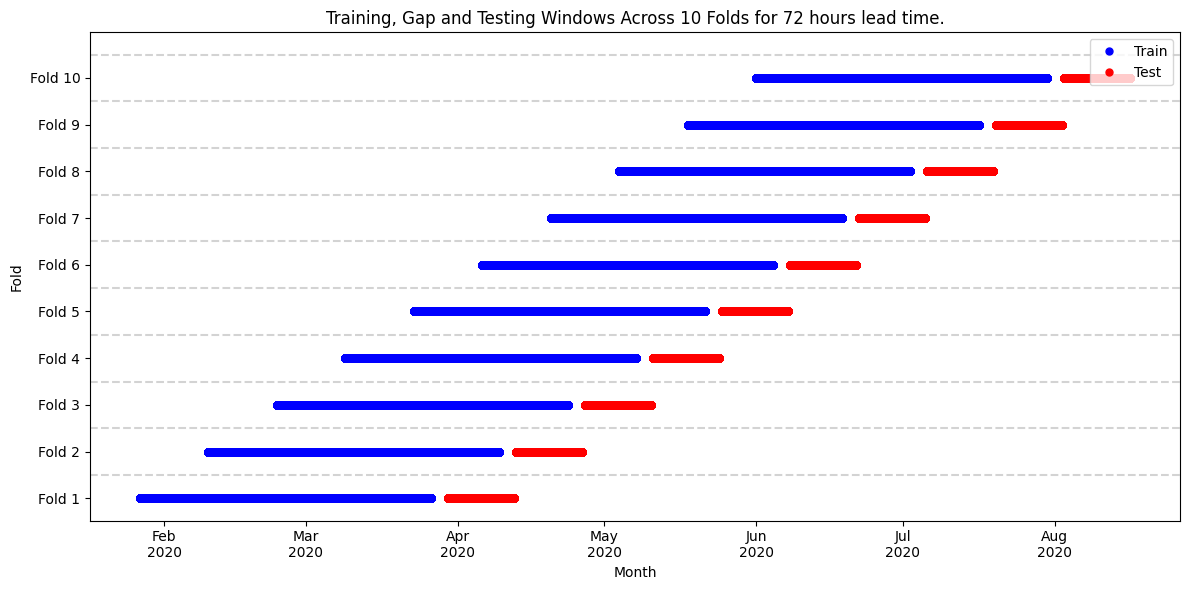

Fold 1:
  mse: 16996.279296875
  PiggyCast: area weighted rmse: 107.85067758111649
  graphcast: area weighted rmse: 124.24322598322598
  pangu: area weighted rmse: 138.2683927137097
  neuralgcm: area weighted rmse: 118.48718467048657
  ifshres: area weighted rmse: 130.20071497038109
Fold 2:
  mse: 24566.22265625
  PiggyCast: area weighted rmse: 109.82539342991352
  graphcast: area weighted rmse: 124.63007878989166
  pangu: area weighted rmse: 136.71986483269285
  neuralgcm: area weighted rmse: 105.18512844769032
  ifshres: area weighted rmse: 131.35725643684688
Fold 3:
  mse: 16633.166015625
  PiggyCast: area weighted rmse: 103.17000040190803
  graphcast: area weighted rmse: 119.20200584161854
  pangu: area weighted rmse: 131.39348642065426
  neuralgcm: area weighted rmse: 112.63722873269602
  ifshres: area weighted rmse: 130.57398337496403
Fold 4:
  mse: 17222.5546875
  PiggyCast: area weighted rmse: 102.07893068854504
  graphcast: area weighted rmse: 116.34549430314604
  pangu: area 

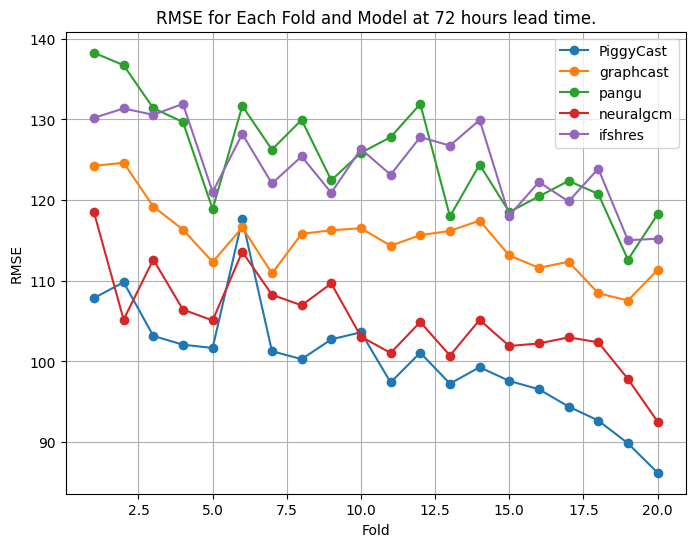

{48: {'PiggyCast': 62.051274579764254,
      'graphcast': 69.45674309067948,
      'ifshres': 73.9548889995106,
      'neuralgcm': 60.79122487980245,
      'pangu': 75.36892184002714},
 72: {'PiggyCast': 100.12133034301823,
      'graphcast': 115.04891079707727,
      'ifshres': 124.49555636933228,
      'neuralgcm': 105.0558212593804,
      'pangu': 125.31061293806769}}


In [15]:
# @title Training and Evaluation Loop- Time series split : 60 Days Training, 3 Day Gap and  14 Days Testing

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=20, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 14, gap=32 * 64 * 2 * 3)

# Lead Times
lead_times=[48, 72]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"======Lead time: {lead_time}========")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)

  # print nicely average RMSE per Leadtime
  average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
  pprint(average_scores)

